# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

You should store the unzipped folder in Drive for use in this Colab notebook.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('/content/gdrive/MyDrive/Colab Notebooks/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [4]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

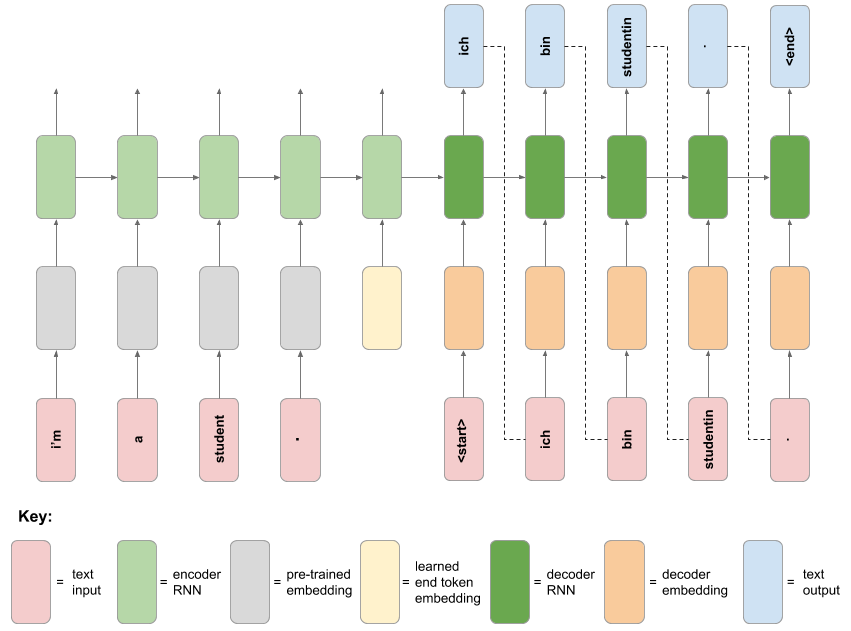

In [5]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [6]:
print(*data_examples[0:5], sep='\n') # displaying first 5 lines of the dataset before preprocessing

Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)

Hi.	Grüß Gott!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)

Run!	Lauf!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)

Wow!	Potzdonner!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)

Wow!	Donnerwetter!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)



In [7]:
s = data_examples[4].split('\t') #split the line at new tabs
print(s)
print("English: ",s[0]) #extract english sentence
print("German: ","<start> "+s[1]+" <end>") #extract german sentence

['Wow!', 'Donnerwetter!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)\n']
English:  Wow!
German:  <start> Donnerwetter! <end>


In [8]:
# do it for every sentence
lines_English = []
lines_German = []
for i in range(len(data_examples)):
    line = data_examples[i].split('\t') #split the lines at new tabs
    lines_English.append(preprocess_sentence(line[0])) #extract english sentence
    lines_German.append("<start> "+preprocess_sentence(line[1])+" <end>") #extract and preprocess german sentence

print(len(lines_English))
print(len(lines_German))

20000
20000


In [9]:
print(type(lines_German))
print(min(lines_German, key=len))

<class 'list'>
<start> aha . <end>


In [10]:
lines_German[40:45]

['<start> ich habe bezahlt . <end>',
 '<start> ich zahlte . <end>',
 '<start> ich sang . <end>',
 '<start> ich schwimme . <end>',
 '<start> ich bin jahre alt . <end>']

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='', #no character filters applied
                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>',
                      document_count=0)

In [12]:
tokenizer.fit_on_texts(lines_German)
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [13]:
import json
word_to_index = json.loads(tokenizer_config['word_index'])
index_to_words = json.loads(tokenizer_config['index_word'])

print(word_to_index)

{'<UNK>': 1, '<start>': 2, '<end>': 3, '.': 4, 'ich': 5, 'tom': 6, 'ist': 7, '?': 8, 'sie': 9, '!': 10, 'es': 11, 'das': 12, 'nicht': 13, 'du': 14, 'er': 15, 'bin': 16, 'hat': 17, 'wir': 18, 'habe': 19, 'ein': 20, 'zu': 21, 'mir': 22, 'mich': 23, 'sind': 24, 'war': 25, ',': 26, 'die': 27, 'ihr': 28, 'dich': 29, 'auf': 30, 'kann': 31, 'uns': 32, 'bist': 33, 'hier': 34, 'sich': 35, 'haben': 36, 'an': 37, 'eine': 38, 'was': 39, 'werde': 40, 'einen': 41, 'aus': 42, 'wie': 43, 'wer': 44, 'ihn': 45, 'gehen': 46, 'in': 47, 'der': 48, 'wird': 49, 'gut': 50, 'mein': 51, 'mag': 52, 'dir': 53, 'den': 54, 'sein': 55, 'mit': 56, 'sehr': 57, 'euch': 58, 'hast': 59, 'geht': 60, 'meine': 61, 'liebe': 62, 'jetzt': 63, 'da': 64, 'lass': 65, 'nach': 66, 'will': 67, 'bitte': 68, 'wurde': 69, 'werden': 70, 'so': 71, 'kein': 72, 'noch': 73, 'seid': 74, 'komm': 75, 'hause': 76, 'mal': 77, 'fuer': 78, 'alle': 79, 'mach': 80, 'gerade': 81, 'koennen': 82, 'auto': 83, 'wo': 84, 'weiss': 85, 'muss': 86, 'machen':

In [14]:
sentences_to_tokens = tokenizer.texts_to_sequences(lines_German)

In [15]:
import random
#printing 5 sentences at random
for i in range(5):
    index = random.randint(0,len(lines_English)-1)
    print("Example ",i,"\n")
    print("English sentence: ", lines_English[index])
    print("German sentence: ", lines_German[index])
    print("Tokenized German sentence: ", sentences_to_tokens[index],"\n")

Example  0 

English sentence:  you aren't alone .
German sentence:  <start> sie sind nicht allein . <end>
Tokenized German sentence:  [2, 9, 24, 13, 140, 4, 3] 

Example  1 

English sentence:  do you know where ?
German sentence:  <start> weisst du , wo ? <end>
Tokenized German sentence:  [2, 534, 14, 26, 84, 8, 3] 

Example  2 

English sentence:  i prefer coffee .
German sentence:  <start> ich bevorzuge kaffee . <end>
Tokenized German sentence:  [2, 5, 4275, 319, 4, 3] 

Example  3 

English sentence:  what caused that ?
German sentence:  <start> was hat das verursacht ? <end>
Tokenized German sentence:  [2, 39, 17, 12, 2917, 8, 3] 

Example  4 

English sentence:  we laughed .
German sentence:  <start> wir lachten . <end>
Tokenized German sentence:  [2, 18, 1827, 4, 3] 



In [16]:
max_len = len(max(sentences_to_tokens, key=len)) #length of longest sentence
print(max_len)

14


In [17]:
#pad the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sentences_to_tokens, maxlen=14, padding='post', value=0)
padded_sequences.shape #(batch, sequence_length)

(20000, 14)

In [18]:
#batch into a numpy arrray
import numpy as np
#padded_sequences = np.expand_dims(padded_sequences, -1) #add feature dimension
print(type(padded_sequences))
print(padded_sequences.shape)

<class 'numpy.ndarray'>
(20000, 14)


## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [19]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [20]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [21]:
# creating training and validation data

m = len(lines_English) #total number of examples
train_size = int(m * 0.8)
val_size = int(m * 0.2)
rand_indx = list(enumerate(np.random.permutation(m)))

data_eng = []
data_ger = []

# random shuffling of dataset
for i, j in rand_indx:
    data_eng.append(lines_English[j])
    data_ger.append(padded_sequences[j])

data_eng = np.array(data_eng)
data_ger = np.array(data_ger)

# create training dataset
train_data_eng = data_eng[:train_size]
train_data_ger = data_ger[:train_size]

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_eng, train_data_ger))

# create test dataset
val_data_eng = data_eng[train_size:]
val_data_ger = data_ger[train_size:]

val_dataset = tf.data.Dataset.from_tensor_slices((val_data_eng, val_data_ger))

In [22]:
print(train_dataset)
print(type(data_eng))

<TensorSliceDataset shapes: ((), (14,)), types: (tf.string, tf.int32)>
<class 'numpy.ndarray'>


<font size=2>The x and y taken by the lambda function represent the english data and the german data of each example</font>

In [23]:
# function for splitting english sentences
def split_eng(dataset):
    return dataset.map(lambda x, y: [tf.strings.split(x, ' '), y]) 

train_dataset = split_eng(train_dataset)
val_dataset = split_eng(val_dataset)

print(train_dataset)
print(val_dataset)


<MapDataset shapes: ((None,), (14,)), types: (tf.string, tf.int32)>
<MapDataset shapes: ((None,), (14,)), types: (tf.string, tf.int32)>


In [24]:
# function to map English word sequences to their respective embedding vectors
def eng_embed(dataset):
    return dataset.map(lambda x, y: [embedding_layer(x), y])

train_dataset_embed = eng_embed(train_dataset)
val_dataset_embed = eng_embed(val_dataset)

print(train_dataset_embed)
print(val_dataset_embed)

<MapDataset shapes: ((None, 128), (14,)), types: (tf.float32, tf.int32)>
<MapDataset shapes: ((None, 128), (14,)), types: (tf.float32, tf.int32)>


In [25]:
k = iter(train_dataset_embed)
print(k.get_next()[0].shape)

(4, 128)


In [28]:
# function to filter out examples where no. of english tokens>= 13
def func(x, m):
    print(type(x))
    print(len(x))
    return len(x)<=m
    
def filter_dataset(dataset, max_tokens=13):
    return dataset.filter(lambda x, y: func(x, max_tokens))

In [29]:
train_dataset_filtered = filter_dataset(train_dataset_embed)
val_dataset_filtered = filter_dataset(val_dataset_embed)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("strided_slice:0", shape=(), dtype=int32)
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("strided_slice:0", shape=(), dtype=int32)


In [30]:
print(train_dataset_filtered)

<FilterDataset shapes: ((None, 128), (14,)), types: (tf.float32, tf.int32)>


In [31]:
p = iter(train_dataset_filtered) # creating an iterator from train_dataset_filtered
print(np.shape(p.get_next()[0])) # display shape of the english sentence embedding of the first element
print(p)

(4, 128)


<font size=2>tf.pad pads a tensor according to the paddings you specify. paddings is an integer tensor with shape [n, 2], where n is the rank of tensor. For each dimension D of input, paddings[D, 0] indicates how many values to add before the contents of tensor in that dimension, and paddings[D, 1] indicates how many values to add after the contents of tensor in that dimension. If mode is "REFLECT" then both paddings[D, 0] and paddings[D, 1] must be no greater than tensor.dim_size(D) - 1. If mode is "SYMMETRIC" then both paddings[D, 0] and paddings[D, 1] must be no greater than tensor.dim_size(D).<br/><br/>

The padded size of each dimension D of the output is:<br/>
paddings[D, 0] + tensor.dim_size(D) + paddings[D, 1]<br/>This is why padding with 13 0s gives a size of 13+#(tokens before) and so we have to return the last 13 tokens from the padded sequence.<br/><br/>
For example, this paddings: [[1, 2], [1, 1], [2, 2], [3, 1]], indicates the rank of the tensor is 4(4 dimensions). For the 0 dimension we add 1 row ahead and 2 rows behind([1, 2]); the 1 dimension we add 1 column ahead and 1 column behind([1, 1]); the dimension 2, 2 ahead and 2 behind([2, 2]); the last dimension, 3 ahead and 1 behind([3, 1]). </font>

In [34]:
# padding english sentences using tf.pad
def pad_English(dataset, pad_len):
    padding = tf.constant([[pad_len, 0], [0, 0]])
    return dataset.map(lambda x, y: [tf.pad(x, padding, "CONSTANT")[-13: , :], y])

In [36]:
train_dataset_eng_padded = pad_English(train_dataset_filtered, 13)
val_dataset_eng_padded = pad_English(val_dataset_filtered, 13)

In [37]:
p = iter(train_dataset_eng_padded)
print(np.shape(p.get_next()[0]))

(13, 128)


In [38]:
batch_size = 16

In [39]:
# creating batches of 16

train_data_batched = train_dataset_eng_padded.batch(batch_size=batch_size)
val_data_batched = val_dataset_eng_padded.batch(batch_size=batch_size)

In [40]:
print(train_data_batched)
print(val_data_batched)

<BatchDataset shapes: ((None, None, 128), (None, 14)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, None, 128), (None, 14)), types: (tf.float32, tf.int32)>


In [41]:
print("Specification of training data: \n", train_data_batched.element_spec)
print("\n")
print("Specification of validation data: \n", val_data_batched.element_spec)

Specification of training data: 
 (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


Specification of validation data: 
 (TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [42]:
print(train_data_batched.take(1))

<TakeDataset shapes: ((None, None, 128), (None, 14)), types: (tf.float32, tf.int32)>


In [43]:
for i in train_data_batched.take(1):
    print(i[0].shape) # (batch_size, max_word, embedding_dim)
    print(type(i[0]))

(16, 13, 128)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [44]:
for i in val_data_batched.take(1):
    print(i[0].shape)

(16, 13, 128)


## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

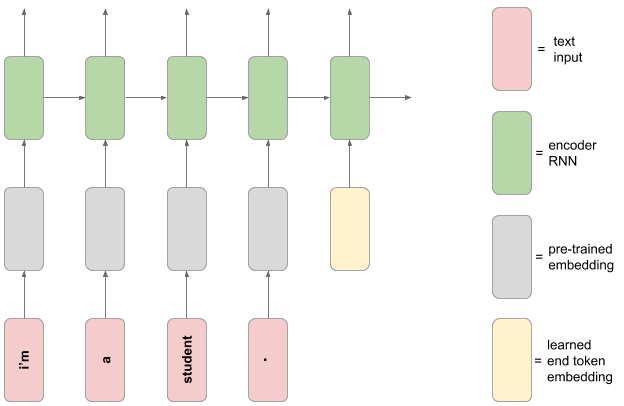

In [45]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [46]:
for i in train_data_batched.take(1):
    for j in i[0]:
        shape = j.shape
        print(shape)
        break

(13, 128)


<font size=2>The end token will have shape (1,128). We have to reshape it as (1, 1, 128) to accomodate for the batch size in axis 0. We have to replicate (using tf.tile or tf.repeat) this (1, 1, 128) shaped tensor 16 times to make it (16, 1, 128).</font>

In [47]:
embedding_dim = 128

In [48]:
from tensorflow.keras.layers import Layer

In [49]:
# custom layer to add trainable end token embedding
class addEndToken(Layer):
    def __init__(self, **kwargs):
        super(addEndToken, self).__init__(**kwargs)
        self.end_token = tf.Variable(tf.random.uniform((1, embedding_dim)), trainable=True)
    
    def call(self, inputs):
        end_token = tf.expand_dims(self.end_token, 0)
        batched_end_tokens = tf.tile(end_token, [tf.shape(inputs)[0], 1, 1])
        #print(inputs.shape)
        return tf.keras.layers.concatenate([inputs, batched_end_tokens], axis=1)

# check out an example
endtokenlayer = addEndToken()
for x, y in train_data_batched.take(1):
    print("before adding end token:\n", x.shape, "\n")
    print("after adding end token:\n", endtokenlayer(x).shape)

before adding end token:
 (16, 13, 128) 

after adding end token:
 (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [50]:
for x, y in train_data_batched.take(1):
    input_shape = x.shape[1:]

In [51]:
print(input_shape)

(13, 128)


<font size=2>final_hidden_state is the output of the last LSTM cell and final_cell_state is the memory cell value of the last LSTM cell.</font>

In [52]:
x = tf.keras.Input(shape=input_shape, name="input_layer") # create input layer for accepting one batch at a time
endTokenAdded = addEndToken()(x) # call layer for adding end token
masked = tf.keras.layers.Masking(mask_value=0.0)(endTokenAdded) # call masking layer
output_sequence, final_hidden_state, final_cell_state = tf.keras.layers.LSTM(units=512, 
                                                                             return_sequences=True, 
                                                                             return_state=True,
                                                                             kernel_initializer="random_uniform")(masked) # each LSTM cell has 512 units
list_outputs = [final_hidden_state, final_cell_state]

In [53]:
modelEncoder = tf.keras.Model(inputs=x, outputs=list_outputs)

In [54]:
print(modelEncoder)

In [55]:
for x, y in train_data_batched.take(1):
    x = modelEncoder(x)
    print(len(x))
    print(x[0].shape, x[1].shape)
    modelEncoder.summary()

2
(16, 512) (16, 512)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 13, 128)]         0         
_________________________________________________________________
add_end_token_1 (addEndToken (None, 14, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 14, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 14, 512), (None,  1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


In [56]:
print(x[0])

tf.Tensor(
[[ 0.02793093  0.02348615  0.03034187 ...  0.0656219   0.01193324
  -0.01021894]
 [ 0.02770679  0.01233659  0.02616488 ...  0.05853548  0.01641103
  -0.01484505]
 [ 0.02908245  0.00809846  0.02505855 ...  0.06899145  0.00647273
  -0.01892687]
 ...
 [ 0.02681721  0.00705854  0.03239537 ...  0.06285115  0.00762557
  -0.03325243]
 [ 0.01718802  0.00461325  0.02665865 ...  0.05685577  0.01188584
  -0.01995228]
 [ 0.02834565  0.01550795  0.02886693 ...  0.06966488  0.01000611
  -0.0206038 ]], shape=(16, 512), dtype=float32)


In [57]:
modelEncoder.trainable_variables

[<tf.Variable 'Variable:0' shape=(1, 128) dtype=float32, numpy=
 array([[0.52668536, 0.29162467, 0.46670413, 0.34513164, 0.82783484,
         0.6568235 , 0.79476154, 0.3612113 , 0.46204317, 0.51756954,
         0.30560136, 0.5622424 , 0.6458082 , 0.19692755, 0.1624564 ,
         0.63814867, 0.04757488, 0.694258  , 0.49285996, 0.02304244,
         0.2856325 , 0.5046786 , 0.00217044, 0.98293877, 0.5852686 ,
         0.67497647, 0.39782536, 0.45995152, 0.7723521 , 0.35626101,
         0.5185158 , 0.29139662, 0.6806172 , 0.84152925, 0.08488059,
         0.21904027, 0.43794215, 0.6665406 , 0.38854873, 0.5888765 ,
         0.8501407 , 0.3590021 , 0.76749516, 0.76069903, 0.43911397,
         0.35285997, 0.01894701, 0.17588508, 0.80895555, 0.3957678 ,
         0.3713566 , 0.54663014, 0.28865552, 0.06166995, 0.16659701,
         0.09054565, 0.47149277, 0.3826245 , 0.30171072, 0.7575562 ,
         0.71662164, 0.41007185, 0.8150041 , 0.4402814 , 0.37823892,
         0.46446598, 0.02909386, 0.7564

## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

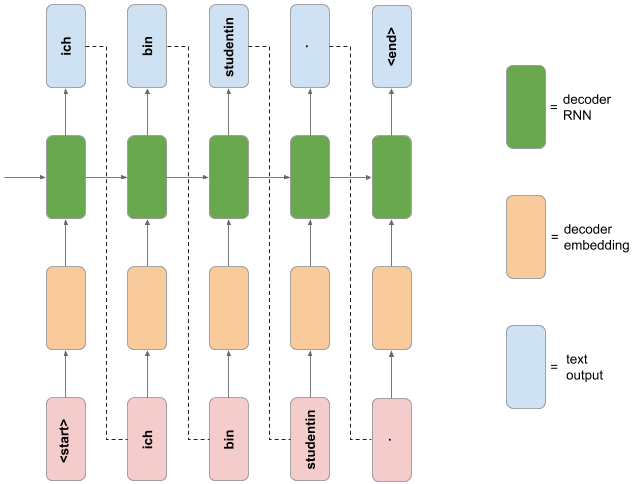

In [58]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [59]:
german_word_count = len(word_to_index)
print(german_word_count)

5744


In [60]:
from tensorflow.keras.models import Model

<font size=2>Feeding target outputs to decoder. Teacher forcing.</font>

In [61]:
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.embedding_layer = tf.keras.layers.Embedding(input_length=14, input_dim=german_word_count+1, output_dim=128, mask_zero=True)
        self.LSTM_layer = tf.keras.layers.LSTM(units=512, return_sequences=True, return_state=True, kernel_initializer="random_uniform")
        self.dense_layer = tf.keras.layers.Dense(units=german_word_count+1)

    def call(self, inputs, hidden_state=None, cell_state=None):
        x = self.embedding_layer(inputs)
        initial_state = [hidden_state, cell_state]
        if initial_state==[None, None]:
            op_seq, hidden_state, cell_state = self.LSTM_layer(x)
        else:
            op_seq, hidden_state, cell_state = self.LSTM_layer(x, initial_state=[hidden_state, cell_state])
        op_from_dense = self.dense_layer(op_seq)
        return [op_from_dense, hidden_state, cell_state]

In [62]:
modelDecoder = Decoder()

In [63]:
for eng, ger in train_data_batched.take(1):
    encoder_hidden_state, encoder_cell_state = modelEncoder(eng)
    decoder_op, decoder_hidden_state, decoder_cell_state = modelDecoder(ger, encoder_hidden_state, encoder_cell_state)
    print(ger)
    print(tf.math.argmax(decoder_op, axis=2))
    print(decoder_hidden_state.shape)
    print(decoder_cell_state.shape)

tf.Tensor(
[[   2    7    6 4955    8    3    0    0    0    0    0    0    0    0]
 [   2    7   15   64  594    8    3    0    0    0    0    0    0    0]
 [   2   14  237   99   42    4    3    0    0    0    0    0    0    0]
 [   2   27 1757    7  301    4    3    0    0    0    0    0    0    0]
 [   2    6  106  155    4    3    0    0    0    0    0    0    0    0]
 [   2   15   25 5560  129    4    3    0    0    0    0    0    0    0]
 [   2    9 1157   12    4    3    0    0    0    0    0    0    0    0]
 [   2   59   14   11  102    8    3    0    0    0    0    0    0    0]
 [   2   75   56   22   26  232    8    3    0    0    0    0    0    0]
 [   2    9   17   23 2601    4    3    0    0    0    0    0    0    0]
 [   2   90  103   10    3    0    0    0    0    0    0    0    0    0]
 [   2    5   67   72  630    4    3    0    0    0    0    0    0    0]
 [   2    9   17   45 5048    4    3    0    0    0    0    0    0    0]
 [   2    5  173 1133 5683    4    3    

In [64]:
modelDecoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  735360    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  2947185   
Total params: 4,995,313
Trainable params: 4,995,313
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [65]:
def generate_dec_in_out(batch_ger_in, hidden_state=None, cell_state=None):
    ger_in = []
    ger_out = []

    z = tf.expand_dims(batch_ger_in, 2) #add feature dimension
    masking = tf.keras.layers.Masking(mask_value=3) #mask out elements with value 3 (token for <end>)
    z = masking(z)
    w = z._keras_mask #get the tensor with boolean mask

    for i in range(w.shape[0]):
        a = np.zeros((w.shape[1]))
        ger_in.append(tf.where(w[i], batch_ger_in[i], a)) #replace elements with value 3 with 0
    
    ger_in = tf.convert_to_tensor(ger_in)
    
    for i in batch_ger_in:
        ger_out.append(tf.concat([i[1:], [0]], 0))

    ger_out = tf.convert_to_tensor(ger_out)
    return ger_in, ger_out

In [70]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [81]:
@tf.function
def train_step(eng_in, ger_in, ger_out):
    loss = 0

    with tf.GradientTape() as tape:
        enc_hidden_state, enc_cell_state = modelEncoder(eng_in)
        dec_op, dec_hidden_state, dec_cell_state = modelDecoder(ger_in, enc_hidden_state, enc_cell_state)
        loss = loss_function(ger_out, dec_op)
    
    trainable_variables = modelEncoder.trainable_variables + modelDecoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return dec_op, loss, gradients

In [80]:
def val_step(eng_in, ger_in, ger_out):
    with tf.GradientTape() as tape:
        enc_hidden_state, enc_cell_state = modelEncoder(eng_in)
        dec_op, dec_hidden_state, dec_cell_state = modelDecoder(ger_in, enc_hidden_state, enc_cell_state)
        loss = loss_function(ger_out, dec_op)
    return dec_op, loss

In [83]:
epochs = 8
train_loss = []
val_loss = []

train_acc = []
val_acc = []

for i in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Accuracy()

    epoch_loss_train = 0
    j = 0
    for x, y in train_data_batched:
        ger_in, ger_out = generate_dec_in_out(y)
        dec_op, batch_loss, gradients = train_step(x, ger_in, ger_out)
        epoch_loss_avg(batch_loss)
        if j%100 == 0:
            print("average train loss in epoch ", i, "after batch: ", j, " loss: ", epoch_loss_avg.result())
        
        epoch_accuracy(y, tf.math.argmax(dec_op, 2))
        j = j + 1

    train_loss.append(epoch_loss_avg.result())
    train_acc.append(epoch_accuracy.result())
    print('Train accuracy after epoch ', i, ': ', epoch_accuracy.result())

    j=0
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Accuracy()
    for x, y in val_data_batched:
        ger_in, ger_out = generate_dec_in_out(y)
        dec_op, batch_loss = val_step(x, ger_in, ger_out)
        epoch_loss_avg(batch_loss)
        if j%100 == 0 or j==249:
            print("average val loss in epoch ", i, "after batch: ", j, " loss: ", epoch_loss_avg.result())

        epoch_accuracy(y, tf.math.argmax(dec_op, 2))
        j = j + 1

    val_loss.append(epoch_loss_avg.result())
    val_acc.append(epoch_accuracy.result())
    print('Val accuracy after epoch ', i, ': ', epoch_accuracy.result())

    print("\n")

average train loss in epoch  0 after batch:  0  loss:  tf.Tensor(8.5361185, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  100  loss:  tf.Tensor(7.057767, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  200  loss:  tf.Tensor(6.8301315, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  300  loss:  tf.Tensor(6.6739655, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  400  loss:  tf.Tensor(6.5594807, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  500  loss:  tf.Tensor(6.46515, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  600  loss:  tf.Tensor(6.3766327, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  700  loss:  tf.Tensor(6.293954, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  800  loss:  tf.Tensor(6.219318, shape=(), dtype=float32)
average train loss in epoch  0 after batch:  900  loss:  tf.Tensor(6.147673, sha

In [ ]:
modelEncoder.save_weights('/content/gdrive/MyDrive/Colab Notebooks/NMT_encoder_weights')
modelDecoder.save_weights('/content/gdrive/MyDrive/Colab Notebooks/NMT_decoder_weights')

In [ ]:
modelEncoder.save_weights('/content/gdrive/MyDrive/Colab Notebooks/NMT_encoder_weights1.h5')
modelDecoder.save_weights('/content/gdrive/MyDrive/Colab Notebooks/NMT_decoder_weights1.h5')

In [84]:
from matplotlib import pyplot as plt

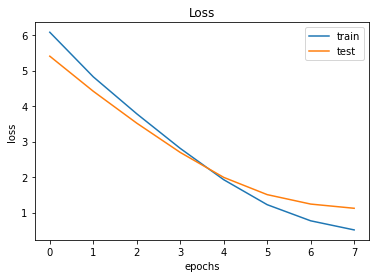

In [91]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

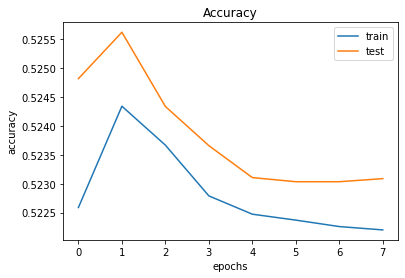

In [90]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [ ]:
random_English_5 = []
random_German_5 = []
ger_start_tokens = []
for i in range(5):
    index = random.randint(0,len(lines_English)-1)
    random_English_5.append(lines_English[index])
    random_German_5.append(lines_German[index])
    ger_start_tokens.append('<start>')

In [ ]:
ger_start_tokens = tokenizer.texts_to_sequences(ger_start_tokens)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((random_English_5, ger_start_tokens))

In [ ]:
dataset = split_eng(dataset) # split english sequences as sequence of words
dataset = eng_embed(dataset) # embed english sequences
dataset = filter_dataset(dataset) # filter out english sequences of length greater than 13
dataset = pad_English(dataset, 13) # pad englisg sequences
dataset_batched = dataset.batch(batch_size=5)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("strided_slice:0", shape=(), dtype=int32)


In [ ]:
# create inference encoder model
enc_input = tf.keras.Input(shape=input_shape, name="input_layer") # create input layer for accepting one batch at a time
endTokenAdded = addEndToken()(enc_input) # call layer for adding end token
masked = tf.keras.layers.Masking(mask_value=0.0)(endTokenAdded) # call masking layer
output_sequence, final_hidden_state, final_cell_state = tf.keras.layers.LSTM(units=512, 
                                                                             return_sequences=True, 
                                                                             return_state=True,
                                                                             kernel_initializer="random_uniform")(masked) # each LSTM cell has 512 units
list_outputs = [final_hidden_state, final_cell_state]

In [ ]:
inference_encoder = tf.keras.Model(inputs=enc_input, outputs=list_outputs)
inference_decoder = Decoder()

In [ ]:
inference_encoder.load_weights('/content/gdrive/MyDrive/Colab Notebooks/NMT_encoder_weights')
inference_decoder.load_weights('/content/gdrive/MyDrive/Colab Notebooks/NMT_decoder_weights')

In [ ]:
count = 1
for eng, ger_start in dataset_batched:
    result = []
    done = []
    encoderHiddenState, encoderCellState = inference_encoder(eng)
    ger_next = ger_start
    decoderHiddenState = encoderHiddenState
    decoderCellState = encoderCellState
    while count!=5:
        decoderOutSeq, decoderHiddenState, decoderCellState = inference_decoder(ger_next, decoderHiddenState, decoderCellState)
        ger_next = tf.argmax(decoderOutSeq, 2)
        if count==1:
            for i in range(5):
                next_word_index = tf.argmax(decoderOutSeq[i], 1).numpy()[0]
                next_word = index_to_words[str(next_word_index)]
                if next_word=='<end>':
                    done.append(i)
                result.append(next_word)
        else:
            for i in range(5):
                if i not in done:
                    next_word_index = tf.argmax(decoderOutSeq[i], 1).numpy()[0]
                    next_word = index_to_words[str(next_word_index)]
                    if next_word=='<end>':
                        done.append(i)
                    result[i] = result[i]+' '+next_word
        count = count + 1

In [ ]:
for i in range(5):
    print('English: ',random_English_5[i])
    print('True German: ',random_German_5[i])
    print('Output: ', result[i])

English:  i opened the door .
True German:  <start> ich oeffnete die tuer . <end>
Output:  ich habe die tuer
English:  you need us .
True German:  <start> sie brauchen uns . <end>
Output:  du brauchst freunde .
English:  is she nice ?
True German:  <start> ist sie nett ? <end>
Output:  ist sie versalzen ?
English:  that looks good .
True German:  <start> das sieht gut aus . <end>
Output:  das sieht gut aus
English:  are you happy ?
True German:  <start> bist du gluecklich ? <end>
Output:  bist du grosszuegig ?
